
# Sentiment Analysis on Amazon Reviews

## Objectives
1. Build two classifiers:
   - Logistic Regression with TFIDF vectorization.
   - Deep Neural Network (DNN).
2. Preprocess the dataset to clean text data.
3. Use K-Folds cross-validation to evaluate models.
4. Provide evaluation metrics such as accuracy, precision, recall, and F1-score.

---



## Dataset Loading and Exploration

Let's load the Amazon reviews dataset and explore its structure. We will look at the dimensions, check for missing values, and plot the distribution of classes to better understand the data.


In [1]:
# Necessary imports
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm import tqdm
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
test_df = pd.read_csv('test.csv', header=None)
train_df = pd.read_csv('train.csv', header=None)

Training Dataset Dimensions: (3600000, 3)
Test Dataset Dimensions: (400000, 3)
Missing values in training set:
0      0
1    207
2      0
dtype: int64
Missing values in test set:
0     0
1    24
2     0
dtype: int64


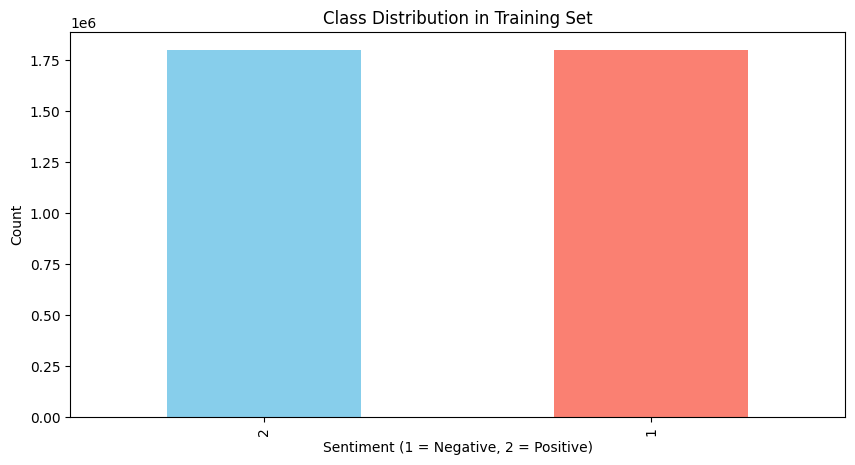

In [3]:

# Dataset dimensions and basic information
print("Training Dataset Dimensions:", train_df.shape)
print("Test Dataset Dimensions:", test_df.shape)

# Check for missing values
print("Missing values in training set:")
print(train_df.isnull().sum())

print("Missing values in test set:")
print(test_df.isnull().sum())

# Plotting class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
train_df[0].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution in Training Set')
plt.xlabel('Sentiment (1 = Negative, 2 = Positive)')
plt.ylabel('Count')
plt.show()


In [4]:
# Drop rows with null values from the original dataset
print("Dropping rows with null values from the original dataset...")
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
print(f"Training dataset size after dropping nulls: {train_df.shape}")
print(f"Testing dataset size after dropping nulls: {test_df.shape}")


Dropping rows with null values from the original dataset...
Training dataset size after dropping nulls: (3599793, 3)
Testing dataset size after dropping nulls: (399976, 3)



## Data Preprocessing

In this step, we will preprocess the dataset to clean the text reviews. The preprocessing steps include:
- Lowercasing
- Removing non-alphabetical characters
- Tokenization
- Lemmatization

We will also use parallelism to speed up the preprocessing.


In [5]:
from joblib import Parallel, delayed
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tqdm import tqdm
import pandas as pd

# Define a standalone function for text cleaning
def clean_text(text, stop_words, char_filter, lemmatizer):
    """
    Clean and preprocess a single text string.
    """
    if not isinstance(text, str) or text.strip() == "":
        return "EMPTY"

    text = text.lower()
    text = char_filter.sub(' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return ' '.join(tokens)


class TextPreprocessor:
    def __init__(self, n_jobs=10):
        self.stop_words = set(stopwords.words('english'))
        self.char_filter = re.compile('[^a-zA-Z\s]')
        self.lemmatizer = WordNetLemmatizer()
        self.n_jobs = n_jobs

    def preprocess_dataset(self, df):
        """
        Preprocess the entire dataset using parallelism with progress reporting.
        """
        processed_df = df.copy()

        for col in [1, 2]:
            print(f"Processing Column {col}...")
            processed_df[col] = Parallel(n_jobs=self.n_jobs)(
                delayed(clean_text)(
                    text, self.stop_words, self.char_filter, self.lemmatizer
                ) for text in tqdm(processed_df[col], desc=f"Column {col}")
            )
        return processed_df


# Example usage
preprocessor = TextPreprocessor()

# Assuming `train_df` and `test_df` are the cleaned DataFrames
print("Processing training dataset...")
processed_train_df = preprocessor.preprocess_dataset(train_df)

print("Processing test dataset...")
processed_test_df = preprocessor.preprocess_dataset(test_df)

# Save processed datasets to CSV files
print("Saving processed datasets to CSV...")
processed_train_df.to_csv("processed_train_df.csv", index=False, header=False)
processed_test_df.to_csv("processed_test_df.csv", index=False, header=False)

print("Processed datasets saved to 'processed_train_df.csv' and 'processed_test_df.csv'")



Processing training dataset...
Processing Column 1...


Column 1: 100%|███████████████████████████████████████████████████████████| 3599793/3599793 [00:18<00:00, 199933.00it/s]


Processing Column 2...


Column 2: 100%|████████████████████████████████████████████████████████████| 3599793/3599793 [01:17<00:00, 46557.19it/s]


Processing test dataset...
Processing Column 1...


Column 1: 100%|█████████████████████████████████████████████████████████████| 399976/399976 [00:01<00:00, 306317.21it/s]


Processing Column 2...


Column 2: 100%|██████████████████████████████████████████████████████████████| 399976/399976 [00:08<00:00, 46795.05it/s]


Saving processed datasets to CSV...
Processed datasets saved to 'processed_train_df.csv' and 'processed_test_df.csv'



## TFIDF Vectorization and Logistic Regression Classifier

Next, we create a logistic regression classifier using TFIDF vectorization of the text data. We use parallelism for vectorization and model fitting where possible.


In [6]:
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold
from tqdm import tqdm
import numpy as np

class ReviewClassifier:
    def __init__(self, max_features=100000, n_jobs=10):
        """
        Initialize the ReviewClassifier with parallelism and TFIDF.
        """
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.model = LogisticRegression(random_state=42, n_jobs=n_jobs)
        self.n_jobs = n_jobs

    def train(self, X_text, y_labels):
        """
        Train the classifier:
        X_text: Series/Array of preprocessed text (reviews)
        y_labels: Series/Array of labels (1 for negative, 2 for positive)
        """
        print("Vectorizing training data...")
        X_tfidf = self.vectorizer.fit_transform(tqdm(X_text, desc="Vectorizing"))

        print("Fitting the Logistic Regression model...")
        self.model.fit(X_tfidf, y_labels)

        print("Training completed!")
        return self.model.score(X_tfidf, y_labels)

    def predict(self, X_text):
        """
        Predict sentiment for new reviews
        """
        print("Vectorizing test data for prediction...")
        X_tfidf = self.vectorizer.transform(tqdm(X_text, desc="Vectorizing Test Data"))
        return self.model.predict(X_tfidf)

    def evaluate(self, X_text, y_true):
        """
        Evaluate the model and return classification report
        """
        print("Evaluating the model...")
        predictions = self.predict(X_text)
        print("Evaluation completed!")
        return classification_report(y_true, predictions)

    def cross_validate(self, X_text, y_labels, n_splits=5):
        """
        Perform K-Folds Cross-Validation with progress reporting.
        X_text: Series/Array of preprocessed text (reviews)
        y_labels: Series/Array of labels (1 for negative, 2 for positive)
        n_splits: Number of folds for K-Folds
        """
        print("Starting K-Folds Cross-Validation...")
        
        # Ensure indices are consistent
        X_text = X_text.reset_index(drop=True)
        y_labels = y_labels.reset_index(drop=True)
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_accuracies = []
    
        for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X_text), 1), total=n_splits, desc="Cross-Validation Progress"):
            X_train, X_test = X_text.iloc[train_index], X_text.iloc[test_index]
            y_train, y_test = y_labels.iloc[train_index], y_labels.iloc[test_index]
    
            print(f"Processing Fold {fold}...")
            X_tfidf_train = self.vectorizer.fit_transform(X_train)
            X_tfidf_test = self.vectorizer.transform(X_test)
            self.model.fit(X_tfidf_train, y_train)
            predictions = self.model.predict(X_tfidf_test)
            accuracy = accuracy_score(y_test, predictions)
            fold_accuracies.append(accuracy)
    
            print(f"Fold {fold} Accuracy: {accuracy}")
            print(classification_report(y_test, predictions))
    
        print(f"Average K-Folds Accuracy: {np.mean(fold_accuracies)}")
        return fold_accuracies




## Model Evaluation

We will evaluate the logistic regression model using:
1. Training accuracy.
2. Test set classification report.
3. K-Folds cross-validation.
4. Confusion matrix visualization.


In [7]:
# Initialize the classifier
classifier = ReviewClassifier(max_features=100000, n_jobs=3)

# Train the model
training_accuracy = classifier.train(processed_train_df[2], train_df[0])
print(f"Training Accuracy: {training_accuracy}")

# Evaluate the model
test_report = classifier.evaluate(processed_test_df[2], test_df[0])
print("\nTest Classification Report:")
print(test_report)

# Perform K-Folds Cross-Validation
kfold_accuracies = classifier.cross_validate(processed_train_df[2], train_df[0], n_splits=5)
print("\nK-Folds Accuracies:")
print(kfold_accuracies)


Vectorizing training data...


Vectorizing: 100%|█████████████████████████████████████████████████████████| 3599793/3599793 [00:37<00:00, 95856.03it/s]


Fitting the Logistic Regression model...
Training completed!
Training Accuracy: 0.8785610728172425
Evaluating the model...
Vectorizing test data for prediction...


Vectorizing Test Data: 100%|█████████████████████████████████████████████████| 399976/399976 [00:04<00:00, 81844.72it/s]


Evaluation completed!

Test Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.87      0.87    199984
           2       0.87      0.88      0.88    199992

    accuracy                           0.88    399976
   macro avg       0.88      0.88      0.88    399976
weighted avg       0.88      0.88      0.88    399976

Starting K-Folds Cross-Validation...


Cross-Validation Progress:   0%|                                                                  | 0/5 [00:00<?, ?it/s]

Processing Fold 1...


Cross-Validation Progress:  20%|███████████▌                                              | 1/5 [00:58<03:55, 58.92s/it]

Fold 1 Accuracy: 0.875909600407801
              precision    recall  f1-score   support

           1       0.88      0.87      0.87    358949
           2       0.87      0.88      0.88    361010

    accuracy                           0.88    719959
   macro avg       0.88      0.88      0.88    719959
weighted avg       0.88      0.88      0.88    719959

Processing Fold 2...


Cross-Validation Progress:  40%|███████████████████████▏                                  | 2/5 [01:53<02:49, 56.43s/it]

Fold 2 Accuracy: 0.8740831075102887
              precision    recall  f1-score   support

           1       0.88      0.87      0.87    360682
           2       0.87      0.88      0.87    359277

    accuracy                           0.87    719959
   macro avg       0.87      0.87      0.87    719959
weighted avg       0.87      0.87      0.87    719959

Processing Fold 3...


Cross-Validation Progress:  60%|██████████████████████████████████▊                       | 3/5 [02:46<01:49, 54.82s/it]

Fold 3 Accuracy: 0.8743178430993988
              precision    recall  f1-score   support

           1       0.88      0.87      0.87    359958
           2       0.87      0.88      0.87    360001

    accuracy                           0.87    719959
   macro avg       0.87      0.87      0.87    719959
weighted avg       0.87      0.87      0.87    719959

Processing Fold 4...


Cross-Validation Progress:  80%|██████████████████████████████████████████████▍           | 4/5 [03:47<00:57, 57.15s/it]

Fold 4 Accuracy: 0.8745801838440576
              precision    recall  f1-score   support

           1       0.88      0.87      0.87    360497
           2       0.87      0.88      0.88    359461

    accuracy                           0.87    719958
   macro avg       0.87      0.87      0.87    719958
weighted avg       0.87      0.87      0.87    719958

Processing Fold 5...


Cross-Validation Progress: 100%|██████████████████████████████████████████████████████████| 5/5 [04:43<00:00, 56.75s/it]

Fold 5 Accuracy: 0.875664969345434
              precision    recall  f1-score   support

           1       0.88      0.87      0.88    359794
           2       0.87      0.88      0.88    360164

    accuracy                           0.88    719958
   macro avg       0.88      0.88      0.88    719958
weighted avg       0.88      0.88      0.88    719958

Average K-Folds Accuracy: 0.874911140841396

K-Folds Accuracies:
[0.875909600407801, 0.8740831075102887, 0.8743178430993988, 0.8745801838440576, 0.875664969345434]


Vectorizing test data for prediction...


Vectorizing Test Data: 100%|█████████████████████████████████████████████████| 399976/399976 [00:04<00:00, 84060.39it/s]


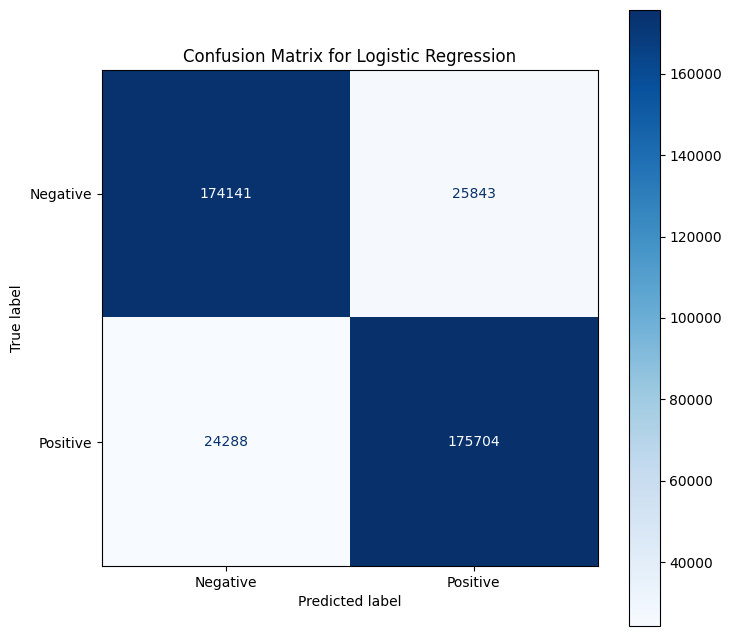

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute predictions
predictions = classifier.predict(processed_test_df[2])

# Compute confusion matrix
conf_matrix = confusion_matrix(test_df[0], predictions)

# Plotting Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()




## Sentiment Analysis on New Reviews

We will test the trained logistic regression model on some new reviews to predict their sentiment.


In [10]:
# Preprocess new reviews using the existing clean_text function
print("Preprocessing new reviews...")
preprocessed_new_reviews = Parallel(n_jobs=preprocessor.n_jobs)(
    delayed(clean_text)(
        review, preprocessor.stop_words, preprocessor.char_filter, preprocessor.lemmatizer
    ) for review in tqdm(new_reviews, desc="Preprocessing New Reviews")
)

# Make predictions
print("Predicting sentiments for new reviews...")
predictions = classifier.predict(preprocessed_new_reviews)

# Display results
print("\nSentiment Analysis Results:")
for original_review, processed_review, prediction in zip(new_reviews, preprocessed_new_reviews, predictions):
    sentiment = "Negative" if prediction == 1 else "Positive"
    print(f"Original Review: {original_review}")
    print(f"Processed Review: {processed_review}")
    print(f"Predicted Sentiment: {sentiment}\n")


Preprocessing new reviews...



Preprocessing New Reviews: 100%|████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 4337.44it/s]


Predicting sentiments for new reviews...
Vectorizing test data for prediction...



Vectorizing Test Data: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14820.86it/s]


Sentiment Analysis Results:
Original Review: I hated this movie
Processed Review: hated movie
Predicted Sentiment: Negative

Original Review: this movie was so good, I love it
Processed Review: movie good love
Predicted Sentiment: Positive

Original Review: I love it so much I could die.
Processed Review: love much could die
Predicted Sentiment: Positive

Original Review: I couldn’t stop laughing at how bad it was!
Processed Review: stop laughing bad
Predicted Sentiment: Positive

Original Review: I couldn’t stop laughing at how bad it was! The best comedy ever made
Processed Review: stop laughing bad best comedy ever made
Predicted Sentiment: Positive

